This repository explains the steps to download and clean MIMIC-IV dataset for analysis.
The repository is compatible with MIMIC-IV v1.0 and MIMIC-IV v2.0

Please go to:
- https://physionet.org/content/mimiciv/1.0/ for v1.0
- https://physionet.org/content/mimiciv/2.0/ for v2.0
- https://physionet.org/content/mimiciv/3.1/ for v3.1
- https://physionet.org/content/mimic-iv-note/2.2/ for Note
- https://physionet.org/content/mimic-cxr/2.1.0/ for CXR

Follow instructions to get access to MIMIC-IV dataset.

Download the files using your terminal: 
- wget -r -N -c -np --user [PHYSIONET USERNAME] --ask-password https://physionet.org/files/mimiciv/1.0/ 
- wget -r -N -c -np --user [PHSYIONET USERNAME] --ask-password https://physionet.org/files/mimiciv/2.0/
- wget -r -N -c -np --user [PHSYIONET USERNAME] --ask-password https://physionet.org/files/mimiciv/3.1/
        

Save downloaded files in the parent directory of this github repo. 

The structure should look like below for v1.0-
- mimiciv/1.0/core
- mimiciv/1.0/hosp
- mimiciv/1.0/icu

The structure should look like below for v2.0-
- mimiciv/2.0/hosp
- mimiciv/2.0/icu

The structure should look like below for v3.1-
- mimiciv/3.1/hosp
- mimiciv/3.1/icu

The structure should look like below for Notes-
- mimiciv/notes

The structure should look like below for DCM Images-
- mimiciv/cxr

In [1]:

import pandas as pd

# Rutas de los archivos
ruta_diagnoses = '/Users/noelia/physionet.org/files/mimiciv/3.1/hosp/diagnoses_icd.csv.gz'
ruta_admissions = '/Users/noelia/physionet.org/files/mimiciv/3.1/hosp/admissions.csv.gz'
ruta_patients = '/Users/noelia/physionet.org/files/mimiciv/3.1/hosp/patients.csv.gz'
ruta_mapeo = '/Users/noelia/Downloads/MIMIC-IV-Data-Pipeline-main/utils/mappings/ICD9_to_ICD10_mapping.txt'

# 1. Cargar los datos necesarios
diagnoses = pd.read_csv(ruta_diagnoses)
admissions = pd.read_csv(ruta_admissions)
patients = pd.read_csv(ruta_patients)
mapeo = pd.read_csv(ruta_mapeo, sep='\t')

# 2. Renombrar columnas de mapeo para el merge
mapeo = mapeo.rename(columns={'icd9cm': 'icd_code', 'icd10cm': 'icd10_code'})

# 3. Definir códigos ICD de Alzheimer
alzheimer_icd9 = ['3310']      # Lista ampliable
alzheimer_icd10 = ['G30', 'G300', 'G301', 'G308', 'G309']      # Lista ampliable

# 4. Filtrar diagnósticos de Alzheimer
icd9_matches = diagnoses[(diagnoses['icd_version'] == 9) & (diagnoses['icd_code'].isin(alzheimer_icd9))]
icd10_matches = diagnoses[(diagnoses['icd_version'] == 10) & (diagnoses['icd_code'].isin(alzheimer_icd10))]

# 5. Mapear ICD-9 a ICD-10
icd9_mapped = icd9_matches.merge(mapeo, on='icd_code', how='left')
icd9_mapped['target_icd10'] = icd9_mapped['icd10_code']

# 6. Unir cohortes ICD-9 e ICD-10
cohort = pd.concat([icd10_matches, icd9_mapped], ignore_index=True)

# 7. Obtener la edad desde patients y unir a admissions
admissions = admissions.merge(patients[['subject_id', 'anchor_age']], on='subject_id', how='left')

# 8. Calcular estancia y filtrar adultos y estancias ≥24 h
admissions['admittime'] = pd.to_datetime(admissions['admittime'])
admissions['dischtime'] = pd.to_datetime(admissions['dischtime'])
admissions['los_days'] = (admissions['dischtime'] - admissions['admittime']).dt.total_seconds() / (24*3600)

adultos_larga_estancia = admissions[(admissions['anchor_age'] >= 18) & (admissions['los_days'] >= 1)]

# 9. Cruzar cohort con patients adultos y estancias largas
cohort_final = cohort[cohort['subject_id'].isin(adultos_larga_estancia['subject_id'])]

# 10. (Opcional) Guardar resultado
cohort_final.to_csv('cohort_alzheimer.csv', index=False)

print(f'Cohorte final guardada con {cohort_final.shape[0]} registros')


Cohorte final guardada con 7424 registros


In [ ]:
import os
print(os.getcwd())

In [2]:
import pandas as pd

# ============================
# 1. Cargar tablas base MIMIC
# ============================
patients  = pd.read_csv('/Users/noelia/physionet.org/files/mimiciv/3.1/hosp/patients.csv.gz')
diagnoses = pd.read_csv('/Users/noelia/physionet.org/files/mimiciv/3.1/hosp/diagnoses_icd.csv.gz')

# Códigos de Alzheimer
alzheimer_icd9  = ['3310']
alzheimer_icd10 = ['G30', 'G300', 'G301', 'G308', 'G309']

# ============================
# 2. Sujetos con Alzheimer adultos (anchor_age >= 18)
# ============================
dx_alz = diagnoses[
    ((diagnoses['icd_version'] == 9)  & (diagnoses['icd_code'].astype(str).isin(alzheimer_icd9))) |
    ((diagnoses['icd_version'] == 10) & (diagnoses['icd_code'].astype(str).isin(alzheimer_icd10)))
]

alz_ids = set(dx_alz['subject_id'])

patients18 = patients[patients['anchor_age'] >= 18]
ids18 = set(patients18['subject_id'])

cohort_ids = alz_ids.intersection(ids18)
subject_ids = sorted(cohort_ids)

print(f"N sujetos Alzheimer >=18: {len(subject_ids)}")

# ============================
# 3. TODOS los diagnósticos de la cohorte (para CCI en R)
# ============================
dx_cohort = diagnoses[diagnoses['subject_id'].isin(cohort_ids)].copy()
dx_cohort.to_csv('/Users/noelia/Downloads/cohort_alzheimer_all_diagnoses.csv', index=False)
print("Guardado: cohort_alzheimer_all_diagnoses.csv (nivel diagnóstico)")

# ============================
# 4. Demografía (nivel paciente)
# ============================
demographics = patients18[patients18['subject_id'].isin(cohort_ids)][
    ['subject_id', 'gender', 'anchor_age']
]

# ============================
# 5. ItemIDs y función de extracción (labs y signos)
# ============================
LAB_ITEMS = {
    'platelets': 51265,
    'creatinine': 50912,
    'bilirubin': 50885,
    'pao2': 50821,
    'fio2': 50816,
    'glucose': 50931,
    'phosphate': 50954,
    'anion_gap': 50868,
    'rdw': 51279,
    'mchc': 51277,
    'base_excess': 50802,
    'alkaline_phosphatase': 50861,
    'hematocrit': 51221,
    'hemoglobin': 51222,
    'urea_nitrogen': 51006,
    'potassium': 50971
}

CHART_ITEMS = {
    'map': [220045, 229624],
    'gcs_eye': 220739,
    'gcs_verbal': 223901,
    'gcs_motor': 223900,
    'resp_rate': 220210,
}

def extract_first_from_large_csv(filename, itemids, subj_ids):
    data = {}
    cols = ['subject_id', 'itemid', 'valuenum']
    for chunk in pd.read_csv(filename, usecols=cols, chunksize=500000):
        chunk = chunk[chunk['subject_id'].isin(subj_ids)]
        if isinstance(itemids, list):
            chunk = chunk[chunk['itemid'].isin(itemids)]
        else:
            chunk = chunk[chunk['itemid'] == itemids]
        for sid, group in chunk.groupby('subject_id'):
            if sid not in data:
                data[sid] = group['valuenum'].iloc[0]
    return pd.Series(data)

# ============================
# 6. Extraer laboratorios (nivel paciente)
# ============================
print("Extrayendo variables de laboratorio...")
labs = {}
for var, iid in LAB_ITEMS.items():
    print(f" - {var}")
    labs[var] = extract_first_from_large_csv(
        '/Users/noelia/physionet.org/files/mimiciv/3.1/hosp/labevents.csv.gz',
        iid, subject_ids
    )

# ============================
# 7. Extraer constantes vitales (nivel paciente)
# ============================
print("Extrayendo variables de chartevents...")
charts = {}
for var, iid in CHART_ITEMS.items():
    print(f" - {var}")
    charts[var] = extract_first_from_large_csv(
        '/Users/noelia/Downloads/physionet.org/files/mimiciv/3.1/icu/chartevents.csv',
        iid, subject_ids
    )

# ============================
# 8. Tabla de features clínicos por subject_id (para MICE)
# ============================
features = pd.DataFrame({'subject_id': subject_ids})
features = features.merge(demographics, on='subject_id', how='left')

for var, series in {**labs, **charts}.items():
    features = features.merge(
        series.rename(var),
        left_on='subject_id',
        right_index=True,
        how='left'
    )

# CSV a nivel PACIENTE -> lo usarás para imputar con MICE en R y para SOFA/GCS en R
features.to_csv('/Users/noelia/Downloads/cohort_alzheimer_raw_features_patients.csv',
                index=False)
print("Guardado: cohort_alzheimer_raw_features_patients.csv (nivel paciente)")

# ============================
# 9. (Opcional) CSV combinado diagnósticos + clínicas
#     Solo si quieres verlo junto; NO lo uses para MICE.
# ============================
cohort_features = dx_cohort.merge(features, on='subject_id', how='left')
cohort_features.to_csv('/Users/noelia/Downloads/cohort_alzheimer_raw_features_full.csv',
                       index=False)
print("Guardado: cohort_alzheimer_raw_features_full.csv (diagnósticos + clínicas)")


N sujetos Alzheimer >=18: 3234
Guardado: cohort_alzheimer_all_diagnoses.csv (nivel diagnóstico)
Extrayendo variables de laboratorio...
 - platelets
 - creatinine
 - bilirubin
 - pao2
 - fio2
 - glucose
 - phosphate
 - anion_gap
 - rdw
 - mchc
 - base_excess
 - alkaline_phosphatase
 - hematocrit
 - hemoglobin
 - urea_nitrogen
 - potassium
Extrayendo variables de chartevents...
 - map
 - gcs_eye
 - gcs_verbal
 - gcs_motor
 - resp_rate
Guardado: cohort_alzheimer_raw_features_patients.csv (nivel paciente)
Guardado: cohort_alzheimer_raw_features_full.csv (diagnósticos + clínicas)


In [3]:
import pandas as pd

df = pd.read_csv("cohort_alzheimer_raw_features_full.csv")

na_pct = df.isna().mean() * 100
print(na_pct)


subject_id               0.000000
hadm_id                  0.000000
seq_num                  0.000000
icd_code                 0.000000
icd_version              0.000000
gender                   0.000000
anchor_age               0.000000
platelets                0.526541
creatinine               0.091324
bilirubin               10.671376
pao2                    38.968322
fio2                    82.053368
glucose                  0.119150
phosphate               29.351455
anion_gap                0.124144
rdw                      0.501570
mchc                     0.501570
base_excess             38.968322
alkaline_phosphatase     9.226598
hematocrit               0.572203
hemoglobin               0.493721
urea_nitrogen            0.091324
potassium                0.143408
map                     49.133847
gcs_eye                 49.211615
gcs_verbal              49.211615
gcs_motor               49.242295
resp_rate               49.133847
dtype: float64


In [11]:

numeric_cols = ['anchor_age','platelets','creatinine','bilirubin','pao2','fio2','map','gcs_eye','gcs_verbal','gcs_motor', 'glucose','anion_gap','rdw','mchc','hematocrit','hemoglobin','urea_nitrogen','potassium']


print(df[numeric_cols].describe())

          anchor_age      platelets     creatinine      bilirubin  \
count  140160.000000  139422.000000  140032.000000  125203.000000   
mean       79.614912     247.492311       1.237539       0.614373   
std         8.919402      96.742862       0.851455       0.805006   
min        41.000000       5.000000       0.300000       0.100000   
25%        74.000000     186.000000       0.800000       0.300000   
50%        81.000000     233.000000       1.000000       0.400000   
75%        86.000000     288.000000       1.300000       0.700000   
max        91.000000    1351.000000      17.600000      36.300000   

               pao2          fio2           map       gcs_eye    gcs_verbal  \
count  85542.000000  24191.000000  66351.000000  71185.000000  71185.000000   
mean     112.172173     61.646555     85.308089      3.404299      5.366706   
std      106.245089     27.638073     16.647784      1.006094      1.189220   
min       14.000000     21.000000     60.000000      1.000000 

In [12]:
import numpy as np

df.loc[df['map'] == 0, 'map'] = np.nan


In [13]:
n_bajos = df[df['fio2'] < 21].shape[0]
print("Filas con FiO2 < 21:", n_bajos)

# Opcional: porcentaje
pct_bajos = (df['fio2'] < 21).mean() * 100
print("Porcentaje con FiO2 < 21:", pct_bajos)


Filas con FiO2 < 21: 0
Porcentaje con FiO2 < 21: 0.0


In [14]:
import numpy as np

df.loc[df['fio2'] < 21, 'fio2'] = np.nan


In [15]:
n_bajos = df[df['map'] < 60].shape[0]
print("Filas con MAP < 60:", n_bajos)

# Opcional: porcentaje
pct_bajos = (df['map'] < 60).mean() * 100
print("Porcentaje con MAP < 60:", pct_bajos)

Filas con MAP < 60: 0
Porcentaje con MAP < 60: 0.0


In [16]:
df.loc[df['map'] < 60, 'map'] = np.nan

In [17]:
df.to_csv("cohort_alzheimer_raw_features_full.csv", index=False)


In [19]:
pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.7 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import numpy as np

# Rutas base MIMIC-IV
HOSP_PATH = "/Users/noelia/physionet.org/files/mimiciv/3.1/hosp"
ICU_PATH  = "/Users/noelia/physionet.org/files/mimiciv/3.1/icu"

# 1) Cargar tablas necesarias
patients   = pd.read_csv(f"{HOSP_PATH}/patients.csv.gz")
admissions = pd.read_csv(f"{HOSP_PATH}/admissions.csv.gz")
icustays   = pd.read_csv(f"{ICU_PATH}/icustays.csv.gz")

# 2) Cargar tu cohorte imputada (nivel subject_id)
df_imp = pd.read_csv("/Users/noelia/Downloads/cohort_alzheimer_imputed_with_sofa_gcs_cci_acci.csv")

# Comprobar que subject_id está
if "subject_id" not in df_imp.columns:
    raise ValueError("El CSV imputado no tiene columna 'subject_id'.")

subject_ids = df_imp["subject_id"].unique().tolist()

# 3) Filtrar admissions e icustays a tu cohorte
adm_cohort = admissions[admissions["subject_id"].isin(subject_ids)].copy()
icu_cohort = icustays[icustays["subject_id"].isin(subject_ids)].copy()

# 4) Definir desenlaces a nivel hospitalización / UCI
#    a) Mortalidad hospitalaria (por hospitalización)
#       deathtime no nulo -> murió en el hospital
adm_cohort["y_mortality_hosp"] = adm_cohort["deathtime"].notna().astype(int)

#    b) Estancia prolongada en UCI (pLOS-ICU)
#       usamos los ICUSTAYS y definimos pLOS >= 3 días (los en días ya viene en 'los')
icu_cohort["y_picu_long"] = (icu_cohort["los"] >= 3.0).astype(int)

# 5) Reducir a una fila por subject_id (puedes cambiar la lógica según tu definición)
#    - Mortalidad: si murió en cualquiera de sus hospitalizaciones -> 1
#    - pLOS UCI: si en alguna UCI tuvo LOS >=3 días -> 1

mortality_by_subject = (
    adm_cohort
    .groupby("subject_id")["y_mortality_hosp"]
    .max()
    .reset_index()
)

picu_long_by_subject = (
    icu_cohort
    .groupby("subject_id")["y_picu_long"]
    .max()
    .reset_index()
)

# 6) Unir desenlaces a tu dataframe imputado (nivel subject_id)
df_outcomes = df_imp.merge(mortality_by_subject, on="subject_id", how="left")
df_outcomes = df_outcomes.merge(picu_long_by_subject, on="subject_id", how="left")

# Rellenar NA con 0 (por ejemplo, sujetos sin ingreso UCI o sin deathtime)
df_outcomes["y_mortality_hosp"] = df_outcomes["y_mortality_hosp"].fillna(0).astype(int)
df_outcomes["y_picu_long"]      = df_outcomes["y_picu_long"].fillna(0).astype(int)


# 8) Guardar CSV final con predictores + desenlaces
df_outcomes.to_csv(
    "/Users/noelia/Downloads/cohort_alzheimer_ml_ready_with_outcomes.csv",
    index=False
)

print("Guardado: cohort_alzheimer_ml_ready_with_outcomes.csv")
print(df_outcomes[["subject_id", "y_mortality_hosp", "y_picu_long"]].head())


Guardado: cohort_alzheimer_ml_ready_with_outcomes.csv
   subject_id  y_mortality_hosp  y_picu_long
0    10002131                 0            0
1    10006501                 0            0
2    10010429                 0            0
3    10014179                 0            0
4    10015785                 0            0


In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

# ===========================
# 1. Cargar datos y definir target
# ===========================
df = pd.read_csv("/Users/noelia/Downloads/cohort_alzheimer_ml_ready_with_outcomes.csv")

# Elegir outcome: mortalidad hospitalaria o pLOS UCI
TARGET = "y_mortality_hosp"   # cambia a "y_picu_long" para el otro análisis

if TARGET not in df.columns:
    raise ValueError(f"No encuentro la columna {TARGET} en el CSV.")

y = df[TARGET].astype(int)

# ===========================
# 2. Predictores tipo Ding (sin CCI, sin SOFA/GCS)
# ===========================
ding_vars = [
    "anchor_age",
    "resp_rate",
    "base_excess",
    "glucose",
    "rdw",
    "alkaline_phosphatase",
    "potassium",
    "hematocrit",
    "phosphate",
    "creatinine",
    # Si tienes MCH, añádelo aquí: "mch",
]

for v in ding_vars:
    if v not in df.columns:
        raise ValueError(f"Falta la variable {v} en el CSV.")

X_ding = df[ding_vars]

num_cols_d = X_ding.columns.tolist()
preprocess_ding = ColumnTransformer(
    transformers=[("num", StandardScaler(), num_cols_d)]
)

X_train_d, X_test_d, y_train, y_test = train_test_split(
    X_ding, y, test_size=0.3, random_state=42, stratify=y
)

def eval_model(pipe, Xtr, Xte, ytr, yte, name):
    pipe.fit(Xtr, ytr)
    y_prob = pipe.predict_proba(Xte)[:, 1]
    auc = roc_auc_score(yte, y_prob)
    print(f"{name} ({TARGET}) AUC: {auc:.3f}")
    return auc, y_prob

# ===========================
# 3. Modelos tipo Ding
# ===========================
# 3.1 Regresión logística
logit = Pipeline(steps=[
    ("prep", preprocess_ding),
    ("model", LogisticRegression(max_iter=2000))
])
eval_model(logit, X_train_d, X_test_d, y_train, y_test, "Logistic (Ding)")

# 3.2 LASSO (logistic L1)
lasso = Pipeline(steps=[
    ("prep", preprocess_ding),
    ("model", LogisticRegressionCV(
        Cs=10,
        cv=5,
        penalty="l1",
        solver="saga",
        scoring="roc_auc",
        max_iter=5000
    ))
])
eval_model(lasso, X_train_d, X_test_d, y_train, y_test, "LASSO (Ding)")

# 3.3 Random Forest
rf = Pipeline(steps=[
    ("prep", preprocess_ding),
    ("model", RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        random_state=42
    ))
])
eval_model(rf, X_train_d, X_test_d, y_train, y_test, "RF (Ding)")

# 3.4 SVM (RBF)
svm_clf = Pipeline(steps=[
    ("prep", preprocess_ding),
    ("model", SVC(
        kernel="rbf",
        probability=True,
        C=1.0,
        gamma="scale",
        random_state=42
    ))
])
eval_model(svm_clf, X_train_d, X_test_d, y_train, y_test, "SVM (Ding)")

# 3.5 XGBoost (opcional)
try:
    import xgboost as xgb

    xgb_clf = Pipeline(steps=[
        ("prep", preprocess_ding),
        ("model", xgb.XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            n_estimators=300,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=1.0,
            reg_lambda=10.0,
            random_state=42
        ))
    ])
    eval_model(xgb_clf, X_train_d, X_test_d, y_train, y_test, "XGBoost (Ding)")
except ImportError:
    print("xgboost no instalado; se omite XGBoost (Ding).")

# ===========================
# 4. Modelos extendidos añadiendo SOFA y GCS (pero SIN CCI/aCCI)
# ===========================
extra_vars = ding_vars + ["sofa_total", "gcs_total"]

for v in extra_vars:
    if v not in df.columns:
        raise ValueError(f"Falta la variable {v} en el CSV.")

X_ext = df[extra_vars]

num_cols_ext = X_ext.columns.tolist()
preprocess_ext = ColumnTransformer(
    transformers=[("num", StandardScaler(), num_cols_ext)]
)

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
    X_ext, y, test_size=0.3, random_state=42, stratify=y
)

# 4.1 Logistic + SOFA/GCS
logit_e = Pipeline(steps=[
    ("prep", preprocess_ext),
    ("model", LogisticRegression(max_iter=2000))
])
eval_model(logit_e, X_train_e, X_test_e, y_train_e, y_test_e,
           "Logistic + SOFA/GCS")

# 4.2 LASSO + SOFA/GCS
lasso_e = Pipeline(steps=[
    ("prep", preprocess_ext),
    ("model", LogisticRegressionCV(
        Cs=10,
        cv=5,
        penalty="l1",
        solver="saga",
        scoring="roc_auc",
        max_iter=5000
    ))
])
eval_model(lasso_e, X_train_e, X_test_e, y_train_e, y_test_e,
           "LASSO + SOFA/GCS")

# 4.3 RF + SOFA/GCS
rf_e = Pipeline(steps=[
    ("prep", preprocess_ext),
    ("model", RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        random_state=42
    ))
])
eval_model(rf_e, X_train_e, X_test_e, y_train_e, y_test_e,
           "RF + SOFA/GCS")

# 4.4 SVM + SOFA/GCS
svm_e = Pipeline(steps=[
    ("prep", preprocess_ext),
    ("model", SVC(
        kernel="rbf",
        probability=True,
        C=1.0,
        gamma="scale",
        random_state=42
    ))
])
eval_model(svm_e, X_train_e, X_test_e, y_train_e, y_test_e,
           "SVM + SOFA/GCS")

# 4.5 XGBoost + SOFA/GCS (si está disponible)
try:
    xgb_e = Pipeline(steps=[
        ("prep", preprocess_ext),
        ("model", xgb.XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            n_estimators=300,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=1.0,
            reg_lambda=10.0,
            random_state=42
        ))
    ])
    eval_model(xgb_e, X_train_e, X_test_e, y_train_e, y_test_e,
               "XGBoost + SOFA/GCS")
except Exception as e:
    print("Error con XGBoost + SOFA/GCS:", e)


Logistic (Ding) (y_mortality_hosp) AUC: 0.595
LASSO (Ding) (y_mortality_hosp) AUC: 0.588
RF (Ding) (y_mortality_hosp) AUC: 0.556
SVM (Ding) (y_mortality_hosp) AUC: 0.509
XGBoost (Ding) (y_mortality_hosp) AUC: 0.578
Logistic + SOFA/GCS (y_mortality_hosp) AUC: 0.714
LASSO + SOFA/GCS (y_mortality_hosp) AUC: 0.714
RF + SOFA/GCS (y_mortality_hosp) AUC: 0.680
SVM + SOFA/GCS (y_mortality_hosp) AUC: 0.586
XGBoost + SOFA/GCS (y_mortality_hosp) AUC: 0.672


In [18]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

# ===========================
# 0. Configuración general
# ===========================
# Elige outcome aquí: mortalidad o LOS UCI prolongada
TARGET = "y_picu_long"      # cambiar a "y_picu_long" para el otro desenlace

# ===========================
# 1. Cargar datos
# ===========================
df = pd.read_csv("/Users/noelia/Downloads/cohort_alzheimer_ml_ready_with_outcomes.csv")

if TARGET not in df.columns:
    raise ValueError(f"No encuentro la columna {TARGET} en el CSV.")

y = df[TARGET].astype(int)

# ===========================
# 2. Variables base (Ding)
# ===========================
ding_vars = [
    "anchor_age",
    "resp_rate",
    "base_excess",
    "glucose",
    "rdw",
    "alkaline_phosphatase",
    "potassium",
    "hematocrit",
    "phosphate",
    "creatinine",
    # "mch",  # descomenta si la tienes
]

for v in ding_vars:
    if v not in df.columns:
        raise ValueError(f"Falta la variable {v} en el CSV.")

# ===========================
# 3. Función de evaluación común
# ===========================
def eval_model(pipe, Xtr, Xte, ytr, yte, name):
    pipe.fit(Xtr, ytr)
    # Probabilidades en train y test
    y_prob_train = pipe.predict_proba(Xtr)[:, 1]
    y_prob_test  = pipe.predict_proba(Xte)[:, 1]

    auc_train = roc_auc_score(ytr, y_prob_train)
    auc_test  = roc_auc_score(yte, y_prob_test)

    print(f"{name} AUC train: {auc_train:.3f} | AUC test: {auc_test:.3f}")
    return auc_train, auc_test, y_prob_test

# ===========================
# 4. Bloque 1: Ding solo
# ===========================
X_ding = df[ding_vars]

prep_ding = ColumnTransformer(
    transformers=[("num", StandardScaler(), X_ding.columns.tolist())]
)

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_ding, y, test_size=0.3, random_state=42, stratify=y
)

# Modelos
logit_d = Pipeline([
    ("prep", prep_ding),
    ("model", LogisticRegression(max_iter=2000))
])
lasso_d = Pipeline([
    ("prep", prep_ding),
    ("model", LogisticRegressionCV(
        Cs=10, cv=5, penalty="l1", solver="saga",
        scoring="roc_auc", max_iter=5000
    ))
])
rf_d = Pipeline([
    ("prep", prep_ding),
    ("model", RandomForestClassifier(
        n_estimators=500, max_depth=None, random_state=42
    ))
])
svm_d = Pipeline([
    ("prep", prep_ding),
    ("model", SVC(
        kernel="rbf", probability=True,
        C=1.0, gamma="scale", random_state=42
    ))
])

print("\n=== BLOQUE 1: Ding solo ===")
eval_model(logit_d, X_train_d, X_test_d, y_train_d, y_test_d, "Logistic (Ding)")
eval_model(lasso_d, X_train_d, X_test_d, y_train_d, y_test_d, "LASSO (Ding)")
eval_model(rf_d,    X_train_d, X_test_d, y_train_d, y_test_d, "RF (Ding)")
eval_model(svm_d,   X_train_d, X_test_d, y_train_d, y_test_d, "SVM (Ding)")

try:
    import xgboost as xgb
    xgb_d = Pipeline([
        ("prep", prep_ding),
        ("model", xgb.XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            n_estimators=300,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=1.0,
            reg_lambda=10.0,
            random_state=42
        ))
    ])
    eval_model(xgb_d, X_train_d, X_test_d, y_train_d, y_test_d, "XGBoost (Ding)")
except ImportError:
    print("xgboost no instalado; se omite XGBoost (Ding).")

# ===========================
# 5. Bloque 2: Ding + SOFA/GCS
# ===========================
extra_vars_2 = ding_vars + ["sofa_total", "gcs_total"]

for v in extra_vars_2:
    if v not in df.columns:
        raise ValueError(f"Falta la variable {v} en el CSV.")

X_ext2 = df[extra_vars_2]

prep_ext2 = ColumnTransformer(
    transformers=[("num", StandardScaler(), X_ext2.columns.tolist())]
)

X_train_e2, X_test_e2, y_train_e2, y_test_e2 = train_test_split(
    X_ext2, y, test_size=0.3, random_state=42, stratify=y
)

logit_e2 = Pipeline([
    ("prep", prep_ext2),
    ("model", LogisticRegression(max_iter=2000))
])
lasso_e2 = Pipeline([
    ("prep", prep_ext2),
    ("model", LogisticRegressionCV(
        Cs=10, cv=5, penalty="l1", solver="saga",
        scoring="roc_auc", max_iter=5000
    ))
])
rf_e2 = Pipeline([
    ("prep", prep_ext2),
    ("model", RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        random_state=42
    ))
])
svm_e2 = Pipeline([
    ("prep", prep_ext2),
    ("model", SVC(
        kernel="rbf",
        probability=True,
        C=1.0,
        gamma="scale",
        random_state=42
    ))
])

print("\n=== BLOQUE 2: Ding + SOFA/GCS ===")
eval_model(logit_e2, X_train_e2, X_test_e2, y_train_e2, y_test_e2,
           "Logistic + SOFA/GCS")
eval_model(lasso_e2, X_train_e2, X_test_e2, y_train_e2, y_test_e2,
           "LASSO + SOFA/GCS")
eval_model(rf_e2,    X_train_e2, X_test_e2, y_train_e2, y_test_e2,
           "RF + SOFA/GCS")
eval_model(svm_e2,   X_train_e2, X_test_e2, y_train_e2, y_test_e2,
           "SVM + SOFA/GCS")

try:
    xgb_e2 = Pipeline([
        ("prep", prep_ext2),
        ("model", xgb.XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            n_estimators=300,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=1.0,
            reg_lambda=10.0,
            random_state=42
        ))
    ])
    eval_model(xgb_e2, X_train_e2, X_test_e2, y_train_e2, y_test_e2,
               "XGBoost + SOFA/GCS")
except Exception as e:
    print("Error XGBoost + SOFA/GCS:", e)

# ===========================
# 6. Bloque 3: Ding + SOFA/GCS + CCI/aCCI
# ===========================
extra_vars_3 = ding_vars + ["sofa_total", "gcs_total", "cci", "acci"]

for v in extra_vars_3:
    if v not in df.columns:
        raise ValueError(f"Falta la variable {v} en el CSV (bloque 3).")

X_ext3 = df[extra_vars_3]

prep_ext3 = ColumnTransformer(
    transformers=[("num", StandardScaler(), X_ext3.columns.tolist())]
)

X_train_e3, X_test_e3, y_train_e3, y_test_e3 = train_test_split(
    X_ext3, y, test_size=0.3, random_state=42, stratify=y
)

logit_e3 = Pipeline([
    ("prep", prep_ext3),
    ("model", LogisticRegression(max_iter=2000))
])
lasso_e3 = Pipeline([
    ("prep", prep_ext3),
    ("model", LogisticRegressionCV(
        Cs=10, cv=5, penalty="l1", solver="saga",
        scoring="roc_auc", max_iter=5000
    ))
])
rf_e3 = Pipeline([
    ("prep", prep_ext3),
    ("model", RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        random_state=42
    ))
])
svm_e3 = Pipeline([
    ("prep", prep_ext3),
    ("model", SVC(
        kernel="rbf",
        probability=True,
        C=1.0,
        gamma="scale",
        random_state=42
    ))
])

print("\n=== BLOQUE 3: Ding + SOFA/GCS + CCI/aCCI ===")
eval_model(logit_e3, X_train_e3, X_test_e3, y_train_e3, y_test_e3,
           "Logistic + SOFA/GCS + CCI/aCCI")
eval_model(lasso_e3, X_train_e3, X_test_e3, y_train_e3, y_test_e3,
           "LASSO + SOFA/GCS + CCI/aCCI")
eval_model(rf_e3,    X_train_e3, X_test_e3, y_train_e3, y_test_e3,
           "RF + SOFA/GCS + CCI/aCCI")
eval_model(svm_e3,   X_train_e3, X_test_e3, y_train_e3, y_test_e3,
           "SVM + SOFA/GCS + CCI/aCCI")

try:
    xgb_e3 = Pipeline([
        ("prep", prep_ext3),
        ("model", xgb.XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            n_estimators=300,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=1.0,
            reg_lambda=10.0,
            random_state=42
        ))
    ])
    eval_model(xgb_e3, X_train_e3, X_test_e3, y_train_e3, y_test_e3,
               "XGBoost + SOFA/GCS + CCI/aCCI")
except Exception as e:
    print("Error XGBoost + SOFA/GCS + CCI/aCCI:", e)



=== BLOQUE 1: Ding solo ===
Logistic (Ding) AUC train: 0.639 | AUC test: 0.535
LASSO (Ding) AUC train: 0.640 | AUC test: 0.539
RF (Ding) AUC train: 1.000 | AUC test: 0.555
SVM (Ding) AUC train: 0.813 | AUC test: 0.527
XGBoost (Ding) AUC train: 0.944 | AUC test: 0.555

=== BLOQUE 2: Ding + SOFA/GCS ===
Logistic + SOFA/GCS AUC train: 0.662 | AUC test: 0.588
LASSO + SOFA/GCS AUC train: 0.662 | AUC test: 0.590
RF + SOFA/GCS AUC train: 1.000 | AUC test: 0.612
SVM + SOFA/GCS AUC train: 0.864 | AUC test: 0.549
XGBoost + SOFA/GCS AUC train: 0.945 | AUC test: 0.605

=== BLOQUE 3: Ding + SOFA/GCS + CCI/aCCI ===
Logistic + SOFA/GCS + CCI/aCCI AUC train: 0.712 | AUC test: 0.650
LASSO + SOFA/GCS + CCI/aCCI AUC train: 0.713 | AUC test: 0.672
RF + SOFA/GCS + CCI/aCCI AUC train: 1.000 | AUC test: 0.675
SVM + SOFA/GCS + CCI/aCCI AUC train: 0.897 | AUC test: 0.624
XGBoost + SOFA/GCS + CCI/aCCI AUC train: 0.950 | AUC test: 0.678


In [10]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

# ===========================
# 0. Configuración general
# ===========================
# Elige outcome aquí: mortalidad o LOS UCI prolongada
TARGET = "y_mortality_hosp"      # cambiar a "y_picu_long" para el otro desenlace

# ===========================
# 1. Cargar datos
# ===========================
df = pd.read_csv("/Users/noelia/Downloads/cohort_alzheimer_ml_ready_with_outcomes.csv")

if TARGET not in df.columns:
    raise ValueError(f"No encuentro la columna {TARGET} en el CSV.")

y = df[TARGET].astype(int)

# ===========================
# 2. Variables base (Ding)
# ===========================
ding_vars = [
    "anchor_age",
    "resp_rate",
    "base_excess",
    "glucose",
    "rdw",
    "alkaline_phosphatase",
    "potassium",
    "hematocrit",
    "phosphate",
    "creatinine",
    # "mch",  # descomenta si la tienes
]

for v in ding_vars:
    if v not in df.columns:
        raise ValueError(f"Falta la variable {v} en el CSV.")

# ===========================
# 3. Función de evaluación común
# ===========================
def eval_model(pipe, Xtr, Xte, ytr, yte, name):
    pipe.fit(Xtr, ytr)
    y_prob = pipe.predict_proba(Xte)[:, 1]
    auc = roc_auc_score(yte, y_prob)
    print(f"{name} ({TARGET}) AUC: {auc:.3f}")
    return auc, y_prob

# ===========================
# 4. Bloque 1: Ding solo
# ===========================
X_ding = df[ding_vars]

prep_ding = ColumnTransformer(
    transformers=[("num", StandardScaler(), X_ding.columns.tolist())]
)

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_ding, y, test_size=0.3, random_state=42, stratify=y
)

# Modelos
logit_d = Pipeline([
    ("prep", prep_ding),
    ("model", LogisticRegression(max_iter=2000))
])
lasso_d = Pipeline([
    ("prep", prep_ding),
    ("model", LogisticRegressionCV(
        Cs=10, cv=5, penalty="l1", solver="saga",
        scoring="roc_auc", max_iter=5000
    ))
])
rf_d = Pipeline([
    ("prep", prep_ding),
    ("model", RandomForestClassifier(
        n_estimators=500, max_depth=None, random_state=42
    ))
])
svm_d = Pipeline([
    ("prep", prep_ding),
    ("model", SVC(
        kernel="rbf", probability=True,
        C=1.0, gamma="scale", random_state=42
    ))
])

print("\n=== BLOQUE 1: Ding solo ===")
eval_model(logit_d, X_train_d, X_test_d, y_train_d, y_test_d, "Logistic (Ding)")
eval_model(lasso_d, X_train_d, X_test_d, y_train_d, y_test_d, "LASSO (Ding)")
eval_model(rf_d,    X_train_d, X_test_d, y_train_d, y_test_d, "RF (Ding)")
eval_model(svm_d,   X_train_d, X_test_d, y_train_d, y_test_d, "SVM (Ding)")

try:
    import xgboost as xgb
    xgb_d = Pipeline([
        ("prep", prep_ding),
        ("model", xgb.XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            n_estimators=300,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=1.0,
            reg_lambda=10.0,
            random_state=42
        ))
    ])
    eval_model(xgb_d, X_train_d, X_test_d, y_train_d, y_test_d, "XGBoost (Ding)")
except ImportError:
    print("xgboost no instalado; se omite XGBoost (Ding).")

# ===========================
# 5. Bloque 2: Ding + SOFA/GCS
# ===========================
extra_vars_2 = ding_vars + ["sofa_total", "gcs_total"]

for v in extra_vars_2:
    if v not in df.columns:
        raise ValueError(f"Falta la variable {v} en el CSV.")

X_ext2 = df[extra_vars_2]

prep_ext2 = ColumnTransformer(
    transformers=[("num", StandardScaler(), X_ext2.columns.tolist())]
)

X_train_e2, X_test_e2, y_train_e2, y_test_e2 = train_test_split(
    X_ext2, y, test_size=0.3, random_state=42, stratify=y
)

logit_e2 = Pipeline([
    ("prep", prep_ext2),
    ("model", LogisticRegression(max_iter=2000))
])
lasso_e2 = Pipeline([
    ("prep", prep_ext2),
    ("model", LogisticRegressionCV(
        Cs=10, cv=5, penalty="l1", solver="saga",
        scoring="roc_auc", max_iter=5000
    ))
])
rf_e2 = Pipeline([
    ("prep", prep_ext2),
    ("model", RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        random_state=42
    ))
])
svm_e2 = Pipeline([
    ("prep", prep_ext2),
    ("model", SVC(
        kernel="rbf",
        probability=True,
        C=1.0,
        gamma="scale",
        random_state=42
    ))
])

print("\n=== BLOQUE 2: Ding + SOFA/GCS ===")
eval_model(logit_e2, X_train_e2, X_test_e2, y_train_e2, y_test_e2,
           "Logistic + SOFA/GCS")
eval_model(lasso_e2, X_train_e2, X_test_e2, y_train_e2, y_test_e2,
           "LASSO + SOFA/GCS")
eval_model(rf_e2,    X_train_e2, X_test_e2, y_train_e2, y_test_e2,
           "RF + SOFA/GCS")
eval_model(svm_e2,   X_train_e2, X_test_e2, y_train_e2, y_test_e2,
           "SVM + SOFA/GCS")

try:
    xgb_e2 = Pipeline([
        ("prep", prep_ext2),
        ("model", xgb.XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            n_estimators=300,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=1.0,
            reg_lambda=10.0,
            random_state=42
        ))
    ])
    eval_model(xgb_e2, X_train_e2, X_test_e2, y_train_e2, y_test_e2,
               "XGBoost + SOFA/GCS")
except Exception as e:
    print("Error XGBoost + SOFA/GCS:", e)

# ===========================
# 6. Bloque 3: Ding + SOFA/GCS + CCI/aCCI
# ===========================
extra_vars_3 = ding_vars + ["sofa_total", "gcs_total", "cci", "acci"]

for v in extra_vars_3:
    if v not in df.columns:
        raise ValueError(f"Falta la variable {v} en el CSV (bloque 3).")

X_ext3 = df[extra_vars_3]

prep_ext3 = ColumnTransformer(
    transformers=[("num", StandardScaler(), X_ext3.columns.tolist())]
)

X_train_e3, X_test_e3, y_train_e3, y_test_e3 = train_test_split(
    X_ext3, y, test_size=0.3, random_state=42, stratify=y
)

logit_e3 = Pipeline([
    ("prep", prep_ext3),
    ("model", LogisticRegression(max_iter=2000))
])
lasso_e3 = Pipeline([
    ("prep", prep_ext3),
    ("model", LogisticRegressionCV(
        Cs=10, cv=5, penalty="l1", solver="saga",
        scoring="roc_auc", max_iter=5000
    ))
])
rf_e3 = Pipeline([
    ("prep", prep_ext3),
    ("model", RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        random_state=42
    ))
])
svm_e3 = Pipeline([
    ("prep", prep_ext3),
    ("model", SVC(
        kernel="rbf",
        probability=True,
        C=1.0,
        gamma="scale",
        random_state=42
    ))
])

print("\n=== BLOQUE 3: Ding + SOFA/GCS + CCI/aCCI ===")
eval_model(logit_e3, X_train_e3, X_test_e3, y_train_e3, y_test_e3,
           "Logistic + SOFA/GCS + CCI/aCCI")
eval_model(lasso_e3, X_train_e3, X_test_e3, y_train_e3, y_test_e3,
           "LASSO + SOFA/GCS + CCI/aCCI")
eval_model(rf_e3,    X_train_e3, X_test_e3, y_train_e3, y_test_e3,
           "RF + SOFA/GCS + CCI/aCCI")
eval_model(svm_e3,   X_train_e3, X_test_e3, y_train_e3, y_test_e3,
           "SVM + SOFA/GCS + CCI/aCCI")

try:
    xgb_e3 = Pipeline([
        ("prep", prep_ext3),
        ("model", xgb.XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            n_estimators=300,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=1.0,
            reg_lambda=10.0,
            random_state=42
        ))
    ])
    eval_model(xgb_e3, X_train_e3, X_test_e3, y_train_e3, y_test_e3,
               "XGBoost + SOFA/GCS + CCI/aCCI")
except Exception as e:
    print("Error XGBoost + SOFA/GCS + CCI/aCCI:", e)



=== BLOQUE 1: Ding solo ===
Logistic (Ding) (y_mortality_hosp) AUC: 0.595
LASSO (Ding) (y_mortality_hosp) AUC: 0.588
RF (Ding) (y_mortality_hosp) AUC: 0.556
SVM (Ding) (y_mortality_hosp) AUC: 0.509
XGBoost (Ding) (y_mortality_hosp) AUC: 0.578

=== BLOQUE 2: Ding + SOFA/GCS ===
Logistic + SOFA/GCS (y_mortality_hosp) AUC: 0.714
LASSO + SOFA/GCS (y_mortality_hosp) AUC: 0.714
RF + SOFA/GCS (y_mortality_hosp) AUC: 0.680
SVM + SOFA/GCS (y_mortality_hosp) AUC: 0.586
XGBoost + SOFA/GCS (y_mortality_hosp) AUC: 0.672

=== BLOQUE 3: Ding + SOFA/GCS + CCI/aCCI ===
Logistic + SOFA/GCS + CCI/aCCI (y_mortality_hosp) AUC: 0.738
LASSO + SOFA/GCS + CCI/aCCI (y_mortality_hosp) AUC: 0.740
RF + SOFA/GCS + CCI/aCCI (y_mortality_hosp) AUC: 0.712
SVM + SOFA/GCS + CCI/aCCI (y_mortality_hosp) AUC: 0.582
XGBoost + SOFA/GCS + CCI/aCCI (y_mortality_hosp) AUC: 0.689


In [11]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score

# ===========================
# 1. Cargar datos
# ===========================
df = pd.read_csv("/Users/noelia/Downloads/cohort_alzheimer_imputed_with_sofa_gcs_cci_acci.csv")

# Punto de corte aCCI "alto" (ajusta si quieres replicar un paper concreto)
# En muchos trabajos usan >4; tú usabas >5, mantengo >5 por consistencia
df["acci_high"] = (df["acci"] > 5).astype(int)

y = df["acci_high"]

# ===========================
# 2. Predictores tipo Ding
# ===========================
ding_vars = [
    "anchor_age",
    "resp_rate",
    "base_excess",
    "glucose",
    "rdw",
    "alkaline_phosphatase",
    "potassium",
    "hematocrit",
    "phosphate",
    "creatinine",
    # "mch",  # si la tienes, añádela
]

for v in ding_vars:
    if v not in df.columns:
        raise ValueError(f"Falta la variable {v} en el CSV.")

X = df[ding_vars]

preprocess = ColumnTransformer(
    transformers=[("num", StandardScaler(), ding_vars)]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ===========================
# 3. LASSO tipo Ding para aCCI alto
# ===========================
lasso_ding = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegressionCV(
        Cs=10,
        cv=5,
        penalty="l1",
        solver="saga",
        scoring="roc_auc",
        max_iter=5000
    ))
])

lasso_ding.fit(X_train, y_train)
y_prob = lasso_ding.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
print(f"LASSO (Ding -> aCCI_high) AUC: {auc:.3f}")

# ===========================
# 4. Extraer coeficientes e importancia de cada variable
# ===========================
# Recuperar el modelo interno
model = lasso_ding.named_steps["model"]

# Como LogisticRegressionCV con L1 puede dar varios Cs, tomamos la media
coefs = model.coef_.mean(axis=0)

results = pd.DataFrame({
    "variable": ding_vars,
    "coef_lasso": coefs
})

# Ordenar por importancia absoluta (tipo Ding)
results["abs_coef"] = results["coef_lasso"].abs()
results = results.sort_values("abs_coef", ascending=False)

print("\nImportancia (tipo Ding) para predecir aCCI alto:")
print(results[["variable", "coef_lasso"]])

# Si quieres guardar la tabla
results.to_csv("/Users/noelia/Downloads/aCCI_ding_importance.csv", index=False)


LASSO (Ding -> aCCI_high) AUC: 0.773

Importancia (tipo Ding) para predecir aCCI alto:
               variable  coef_lasso
0            anchor_age    0.915381
3               glucose    0.419362
9            creatinine    0.283800
7            hematocrit   -0.213539
1             resp_rate    0.111452
8             phosphate    0.040079
4                   rdw    0.025693
6             potassium    0.017433
2           base_excess   -0.015694
5  alkaline_phosphatase   -0.000169


In [12]:
import pandas as pd

# Cargar dataset clínico imputado
df = pd.read_csv("/Users/noelia/Downloads/cohort_alzheimer_imputed_with_sofa_gcs_cci_acci.csv")

# 1) ACCI alto (>5)
df["acci_high"] = (df["acci"] > 5).astype(int)

# 2) SOFA alto (>=8)
df["sofa_high"] = (df["sofa_total"] >= 8).astype(int)

# 3) GCS bajo (<=8)
df["gcs_low"] = (df["gcs_total"] <= 8).astype(int)

# Guardar
df.to_csv(
    "/Users/noelia/Downloads/cohort_alzheimer_imputed_with_sofa_gcs_cci_acci_labels.csv",
    index=False
)

print(df[["subject_id", "acci", "acci_high", "sofa_total", "sofa_high",
          "gcs_total", "gcs_low"]].head())


   subject_id  acci  acci_high  sofa_total  sofa_high  gcs_total  gcs_low
0    10002131     6          1           4          0         15        0
1    10006501     3          0           8          1          3        1
2    10010429     5          0           7          0         11        0
3    10014179     9          1           7          0         14        0
4    10015785     7          1           8          1          9        0


In [20]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score

# 1. Cargar datos
df = pd.read_csv("/Users/noelia/Downloads/cohort_alzheimer_imputed_with_sofa_gcs_cci_acci_labels.csv")

# Target: ACCI alto (>5)
y = df["acci_high"].astype(int)

# 2. Predictores tipo Ding
ding_vars = [
    "anchor_age",
    "resp_rate",
    "base_excess",
    "glucose",
    "rdw",
    "alkaline_phosphatase",
    "potassium",
    "hematocrit",
    "phosphate",
    "creatinine",
]

for v in ding_vars:
    if v not in df.columns:
        raise ValueError(f"Falta la variable {v} en el CSV.")

X = df[ding_vars]

preprocess = ColumnTransformer(
    transformers=[("num", StandardScaler(), ding_vars)]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 3. LASSO tipo Ding
pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegressionCV(
        Cs=10,
        cv=5,
        penalty="l1",
        solver="saga",
        scoring="roc_auc",
        max_iter=5000
    ))
])

pipe.fit(X_train, y_train)

# AUC en train y test
y_prob_train = pipe.predict_proba(X_train)[:, 1]
y_prob_test  = pipe.predict_proba(X_test)[:, 1]

auc_train = roc_auc_score(y_train, y_prob_train)
auc_test  = roc_auc_score(y_test,  y_prob_test)

print(f"LASSO (Ding -> acci_high) AUC train: {auc_train:.3f} | AUC test: {auc_test:.3f}")

# 4. Coeficientes (importancia tipo Ding)
model = pipe.named_steps["model"]
coefs = model.coef_.mean(axis=0)

res_acci = pd.DataFrame({
    "variable": ding_vars,
    "coef_lasso": coefs
})
res_acci["abs_coef"] = res_acci["coef_lasso"].abs()
res_acci = res_acci.sort_values("abs_coef", ascending=False)

print("\nImportancia para acci_high:")
print(res_acci[["variable", "coef_lasso"]])

res_acci.to_csv("/Users/noelia/Downloads/acci_ding_importance.csv", index=False)


LASSO (Ding -> acci_high) AUC train: 0.778 | AUC test: 0.773

Importancia para acci_high:
               variable  coef_lasso
0            anchor_age    0.915380
3               glucose    0.419363
9            creatinine    0.283843
7            hematocrit   -0.213525
1             resp_rate    0.111451
8             phosphate    0.040084
4                   rdw    0.025680
6             potassium    0.017427
2           base_excess   -0.015688
5  alkaline_phosphatase   -0.000170


In [21]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score

df = pd.read_csv("/Users/noelia/Downloads/cohort_alzheimer_imputed_with_sofa_gcs_cci_acci_labels.csv")

ding_vars = [
    "anchor_age",
    "resp_rate",
    "base_excess",
    "glucose",
    "rdw",
    "alkaline_phosphatase",
    "potassium",
    "hematocrit",
    "phosphate",
    "creatinine",
]

for v in ding_vars:
    if v not in df.columns:
        raise ValueError(f"Falta la variable {v} en el CSV.")

X = df[ding_vars]

preprocess = ColumnTransformer(
    transformers=[("num", StandardScaler(), ding_vars)]
)

def fit_lasso_for_target(target_name, out_csv):
    if target_name not in df.columns:
        raise ValueError(f"No encuentro la columna {target_name}.")
    y = df[target_name].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    pipe = Pipeline(steps=[
        ("prep", preprocess),
        ("model", LogisticRegressionCV(
            Cs=10,
            cv=5,
            penalty="l1",
            solver="saga",
            scoring="roc_auc",
            max_iter=5000
        ))
    ])

    pipe.fit(X_train, y_train)

    # Probabilidades en train y test
    y_prob_train = pipe.predict_proba(X_train)[:, 1]
    y_prob_test  = pipe.predict_proba(X_test)[:, 1]

    auc_train = roc_auc_score(y_train, y_prob_train)
    auc_test  = roc_auc_score(y_test,  y_prob_test)

    print(f"LASSO (Ding -> {target_name}) AUC train: {auc_train:.3f} | AUC test: {auc_test:.3f}")

    # Coeficientes
    model = pipe.named_steps["model"]
    coefs = model.coef_.mean(axis=0)

    res = pd.DataFrame({
        "variable": ding_vars,
        "coef_lasso": coefs
    })
    res["abs_coef"] = res["coef_lasso"].abs()
    res = res.sort_values("abs_coef", ascending=False)

    print(f"\nImportancia para {target_name}:")
    print(res[["variable", "coef_lasso"]])

    res.to_csv(out_csv, index=False)

# SOFA alto (>=8)
fit_lasso_for_target(
    "sofa_high",
    "/Users/noelia/Downloads/sofa_high_ding_importance.csv"
)

# GCS bajo (<=8)
fit_lasso_for_target(
    "gcs_low",
    "/Users/noelia/Downloads/gcs_low_ding_importance.csv"
)


LASSO (Ding -> sofa_high) AUC train: 0.739 | AUC test: 0.661

Importancia para sofa_high:
               variable  coef_lasso
9            creatinine    1.175457
4                   rdw   -0.384426
7            hematocrit    0.379470
1             resp_rate   -0.228472
2           base_excess   -0.209184
5  alkaline_phosphatase    0.144561
3               glucose    0.134911
0            anchor_age    0.102525
8             phosphate    0.097869
6             potassium   -0.037311
LASSO (Ding -> gcs_low) AUC train: 0.594 | AUC test: 0.611

Importancia para gcs_low:
               variable  coef_lasso
4                   rdw   -0.313541
7            hematocrit    0.307607
2           base_excess   -0.227617
3               glucose    0.129433
8             phosphate    0.101854
1             resp_rate   -0.078523
0            anchor_age   -0.060142
6             potassium   -0.048318
5  alkaline_phosphatase   -0.047967
9            creatinine   -0.027766


In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

df = pd.read_csv("/Users/noelia/Downloads/cohort_alzheimer_imputed_with_sofa_gcs_cci_acci_labels.csv")

# Target: ACCI alto (>5)
y = df["acci_high"].astype(int)

ding_vars = [
    "anchor_age",
    "resp_rate",
    "base_excess",
    "glucose",
    "rdw",
    "alkaline_phosphatase",
    "potassium",
    "hematocrit",
    "phosphate",
    "creatinine",
]

X = df[ding_vars]

preprocess = ColumnTransformer(
    transformers=[("num", StandardScaler(), ding_vars)]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

logit = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(
        penalty=None,    # sin L1/L2
        max_iter=5000
    ))
])

logit.fit(X_train, y_train)

# Probabilidades en train y test
y_prob_train = logit.predict_proba(X_train)[:, 1]
y_prob_test  = logit.predict_proba(X_test)[:, 1]

auc_train = roc_auc_score(y_train, y_prob_train)
auc_test  = roc_auc_score(y_test,  y_prob_test)

print(f"Logistic (Ding -> acci_high) AUC train: {auc_train:.3f} | AUC test: {auc_test:.3f}")

# Coeficientes
model = logit.named_steps["model"]
coefs = model.coef_[0]

res_acci = pd.DataFrame({
    "variable": ding_vars,
    "coef_logit": coefs
}).sort_values("coef_logit", key=lambda s: s.abs(), ascending=False)

print("\nCoeficientes logística acci_high:")
print(res_acci)


Logistic (Ding -> acci_high) AUC train: 0.778 | AUC test: 0.774

Coeficientes logística acci_high:
               variable  coef_logit
0            anchor_age    0.927514
3               glucose    0.430861
9            creatinine    0.299614
7            hematocrit   -0.273237
1             resp_rate    0.119382
4                   rdw    0.087971
8             phosphate    0.053856
6             potassium    0.024493
2           base_excess   -0.022823
5  alkaline_phosphatase   -0.012696


In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

df = pd.read_csv("/Users/noelia/Downloads/cohort_alzheimer_imputed_with_sofa_gcs_cci_acci_labels.csv")

ding_vars = [
    "anchor_age",
    "resp_rate",
    "base_excess",
    "glucose",
    "rdw",
    "alkaline_phosphatase",
    "potassium",
    "hematocrit",
    "phosphate",
    "creatinine",
]

X = df[ding_vars]

preprocess = ColumnTransformer(
    transformers=[("num", StandardScaler(), ding_vars)]
)

def fit_logit_for_target(target_name, out_csv):
    y = df[target_name].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    pipe = Pipeline(steps=[
        ("prep", preprocess),
        ("model", LogisticRegression(
            penalty=None,
            max_iter=5000
        ))
    ])

    pipe.fit(X_train, y_train)

    # Probabilidades en train y test
    y_prob_train = pipe.predict_proba(X_train)[:, 1]
    y_prob_test  = pipe.predict_proba(X_test)[:, 1]

    auc_train = roc_auc_score(y_train, y_prob_train)
    auc_test  = roc_auc_score(y_test,  y_prob_test)

    print(f"Logistic (Ding -> {target_name}) AUC train: {auc_train:.3f} | AUC test: {auc_test:.3f}")

    model = pipe.named_steps["model"]
    coefs = model.coef_[0]

    res = pd.DataFrame({
        "variable": ding_vars,
        "coef_logit": coefs
    }).sort_values("coef_logit", key=lambda s: s.abs(), ascending=False)

    print(f"\nCoeficientes logística {target_name}:")
    print(res)

    res.to_csv(out_csv, index=False)

# SOFA alto (>=8)
fit_logit_for_target(
    "sofa_high",
    "/Users/noelia/Downloads/sofa_high_ding_logistic_coefs.csv"
)

# GCS bajo (<=8)
fit_logit_for_target(
    "gcs_low",
    "/Users/noelia/Downloads/gcs_low_ding_logistic_coefs.csv"
)


Logistic (Ding -> sofa_high) AUC train: 0.738 | AUC test: 0.661

Coeficientes logística sofa_high:
               variable  coef_logit
9            creatinine    1.210221
4                   rdw   -0.467601
7            hematocrit    0.466599
1             resp_rate   -0.244928
2           base_excess   -0.215424
5  alkaline_phosphatase    0.152130
3               glucose    0.145369
0            anchor_age    0.114042
8             phosphate    0.105976
6             potassium   -0.053639
Logistic (Ding -> gcs_low) AUC train: 0.594 | AUC test: 0.611

Coeficientes logística gcs_low:
               variable  coef_logit
4                   rdw   -0.323442
7            hematocrit    0.317124
2           base_excess   -0.228776
3               glucose    0.130632
8             phosphate    0.103098
1             resp_rate   -0.079873
0            anchor_age   -0.060950
5  alkaline_phosphatase   -0.050032
6             potassium   -0.049698
9            creatinine   -0.029003


In [24]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score

df = pd.read_csv("/Users/noelia/Downloads/cohort_alzheimer_imputed_with_sofa_gcs_cci_acci_labels.csv")

# Target: ACCI alto (>5)
y = df["acci_high"].astype(int)

ding_vars = [
    "anchor_age",
    "resp_rate",
    "base_excess",
    "glucose",
    "rdw",
    "alkaline_phosphatase",
    "potassium",
    "hematocrit",
    "phosphate",
    "creatinine",
]

for v in ding_vars:
    if v not in df.columns:
        raise ValueError(f"Falta la variable {v} en el CSV.")

X = df[ding_vars]

preprocess = ColumnTransformer(
    transformers=[("num", StandardScaler(), ding_vars)]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegressionCV(
        Cs=10,
        cv=5,
        penalty="l1",
        solver="saga",
        scoring="roc_auc",
        max_iter=5000
    ))
])

pipe.fit(X_train, y_train)

# AUC train y test
y_prob_train = pipe.predict_proba(X_train)[:, 1]
y_prob_test  = pipe.predict_proba(X_test)[:, 1]

auc_train = roc_auc_score(y_train, y_prob_train)
auc_test  = roc_auc_score(y_test,  y_prob_test)

print(f"LASSO (Ding -> acci_high) AUC train: {auc_train:.3f} | AUC test: {auc_test:.3f}")

# Coeficientes medios LASSO
model = pipe.named_steps["model"]
coefs = model.coef_.mean(axis=0)

res_acci = pd.DataFrame({
    "variable": ding_vars,
    "coef_lasso": coefs
})
res_acci["abs_coef"] = res_acci["coef_lasso"].abs()
res_acci = res_acci.sort_values("abs_coef", ascending=False)

print("\nImportancia LASSO para acci_high:")
print(res_acci[["variable", "coef_lasso"]])

res_acci.to_csv("/Users/noelia/Downloads/acci_ding_lasso_importance.csv", index=False)


LASSO (Ding -> acci_high) AUC train: 0.778 | AUC test: 0.773

Importancia LASSO para acci_high:
               variable  coef_lasso
0            anchor_age    0.915324
3               glucose    0.419487
9            creatinine    0.283852
7            hematocrit   -0.211786
1             resp_rate    0.111430
8             phosphate    0.040040
4                   rdw    0.023946
6             potassium    0.017335
2           base_excess   -0.015668
5  alkaline_phosphatase   -0.000206


In [25]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

import xgboost as xgb

# 1. Cargar datos
df = pd.read_csv("/Users/noelia/Downloads/cohort_alzheimer_imputed_with_sofa_gcs_cci_acci_labels.csv")

# Target: aCCI alto (>5)
y = df["acci_high"].astype(int)

# 2. Variables tipo Ding (11 si tienes MCH)
ding_vars = [
    "anchor_age",
    "resp_rate",
    "base_excess",
    "glucose",
    "rdw",
    "alkaline_phosphatase",
    "potassium",
    "hematocrit",
    "phosphate",
    "creatinine",
    # "mch",  # descomenta si la tienes en el CSV
]

for v in ding_vars:
    if v not in df.columns:
        raise ValueError(f"Falta la variable {v} en el CSV.")

X = df[ding_vars]

# 3. Preprocesado (escalado)
preprocess = ColumnTransformer(
    transformers=[("num", StandardScaler(), ding_vars)]
)

# 4. Train / test 70/30 como en Ding
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# 5. Modelo XGBoost tipo Ding
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=800,     # muchas trees -> alta capacidad
    max_depth=4,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,        # L1
    reg_lambda=10.0,      # L2
    n_jobs=-1,
    random_state=42
)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", xgb_model)
])

# 6. Entrenar y evaluar
pipe.fit(X_train, y_train)

# Probabilidades en train y test
y_prob_train = pipe.predict_proba(X_train)[:, 1]
y_prob_test  = pipe.predict_proba(X_test)[:, 1]

auc_train = roc_auc_score(y_train, y_prob_train)
auc_test  = roc_auc_score(y_test,  y_prob_test)

print(f"XGBoost (Ding -> acci_high) AUC train: {auc_train:.3f} | AUC test: {auc_test:.3f}")

# 7. Importancia de variables (tipo figura 5 de Ding)
#    Hay que acceder al booster interno, así que reentrenamos sin el Pipeline para obtener importances en escala original
xgb_model.fit(
    StandardScaler().fit_transform(X_train),
    y_train
)

importances = xgb_model.feature_importances_

imp_df = pd.DataFrame({
    "variable": ding_vars,
    "importance": importances
}).sort_values("importance", ascending=False)

print("\nImportancia XGBoost para acci_high:")
print(imp_df)

imp_df.to_csv("/Users/noelia/Downloads/acci_ding_xgboost_importance.csv", index=False)


XGBoost (Ding -> acci_high) AUC train: 0.952 | AUC test: 0.789

Importancia XGBoost para acci_high:
               variable  importance
0            anchor_age    0.315154
9            creatinine    0.150288
3               glucose    0.091976
4                   rdw    0.073834
7            hematocrit    0.068205
6             potassium    0.065936
5  alkaline_phosphatase    0.062250
8             phosphate    0.058176
1             resp_rate    0.057909
2           base_excess    0.056272


In [26]:
df = pd.read_csv("/Users/noelia/Downloads/cohort_alzheimer_imputed_with_sofa_gcs_cci_acci_labels.csv")

y = df["acci_high"].astype(int)

print("Recuento clases acci_high:")
print(y.value_counts())

print("\nProporciones acci_high:")
print(y.value_counts(normalize=True))

Recuento clases acci_high:
1    2216
0    1018
Name: acci_high, dtype: int64

Proporciones acci_high:
1    0.68522
0    0.31478
Name: acci_high, dtype: float64


In [27]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score

df = pd.read_csv("/Users/noelia/Downloads/cohort_alzheimer_imputed_with_sofa_gcs_cci_acci_labels.csv")

# Target: ACCI alto (>5)
y = df["acci_high"].astype(int)

ding_vars = [
    "anchor_age",
    "resp_rate",
    "base_excess",
    "glucose",
    "rdw",
    "alkaline_phosphatase",
    "potassium",
    "hematocrit",
    "phosphate",
    "creatinine",
]

for v in ding_vars:
    if v not in df.columns:
        raise ValueError(f"Falta la variable {v} en el CSV.")

X = df[ding_vars]

preprocess = ColumnTransformer(
    transformers=[("num", StandardScaler(), ding_vars)]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegressionCV(
        Cs=10,
        cv=5,
        penalty="l1",
        solver="saga",
        scoring="roc_auc",
        max_iter=5000,
        class_weight="balanced"   # <-- añadido por desbalance moderado
    ))
])

pipe.fit(X_train, y_train)

# AUC train y test
y_prob_train = pipe.predict_proba(X_train)[:, 1]
y_prob_test  = pipe.predict_proba(X_test)[:, 1]

auc_train = roc_auc_score(y_train, y_prob_train)
auc_test  = roc_auc_score(y_test,  y_prob_test)

print(f"LASSO balanced (Ding -> acci_high) AUC train: {auc_train:.3f} | AUC test: {auc_test:.3f}")

# Coeficientes medios LASSO
model = pipe.named_steps["model"]
coefs = model.coef_.mean(axis=0)

res_acci = pd.DataFrame({
    "variable": ding_vars,
    "coef_lasso": coefs
})
res_acci["abs_coef"] = res_acci["coef_lasso"].abs()
res_acci = res_acci.sort_values("abs_coef", ascending=False)

print("\nImportancia LASSO balanced para acci_high:")
print(res_acci[["variable", "coef_lasso"]])

res_acci.to_csv("/Users/noelia/Downloads/acci_ding_lasso_importance_balanced.csv", index=False)


LASSO balanced (Ding -> acci_high) AUC train: 0.775 | AUC test: 0.768

Importancia LASSO balanced para acci_high:
               variable  coef_lasso
0            anchor_age    0.918627
3               glucose    0.360533
7            hematocrit   -0.166540
9            creatinine    0.162423
1             resp_rate    0.079070
6             potassium    0.005294
2           base_excess    0.000000
4                   rdw    0.000000
5  alkaline_phosphatase    0.000000
8             phosphate    0.000000


In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

df = pd.read_csv("/Users/noelia/Downloads/cohort_alzheimer_imputed_with_sofa_gcs_cci_acci_labels.csv")

# Target: ACCI alto (>5)
y = df["acci_high"].astype(int)

ding_vars = [
    "anchor_age",
    "resp_rate",
    "base_excess",
    "glucose",
    "rdw",
    "alkaline_phosphatase",
    "potassium",
    "hematocrit",
    "phosphate",
    "creatinine",
]

X = df[ding_vars]

preprocess = ColumnTransformer(
    transformers=[("num", StandardScaler(), ding_vars)]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

logit = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(
        penalty=None,        # sin L1/L2
        max_iter=5000,
        class_weight="balanced"   # <-- ajuste por desbalance
    ))
])

logit.fit(X_train, y_train)

# Probabilidades en train y test
y_prob_train = logit.predict_proba(X_train)[:, 1]
y_prob_test  = logit.predict_proba(X_test)[:, 1]

auc_train = roc_auc_score(y_train, y_prob_train)
auc_test  = roc_auc_score(y_test,  y_prob_test)

print(f"Logistic balanced (Ding -> acci_high) AUC train: {auc_train:.3f} | AUC test: {auc_test:.3f}")

# Coeficientes
model = logit.named_steps["model"]
coefs = model.coef_[0]

res_acci = pd.DataFrame({
    "variable": ding_vars,
    "coef_logit": coefs
}).sort_values("coef_logit", key=lambda s: s.abs(), ascending=False)

print("\nCoeficientes logística balanced acci_high:")
print(res_acci)


Logistic balanced (Ding -> acci_high) AUC train: 0.776 | AUC test: 0.770

Coeficientes logística balanced acci_high:
               variable  coef_logit
0            anchor_age    0.989675
3               glucose    0.446264
7            hematocrit   -0.261009
9            creatinine    0.207915
1             resp_rate    0.131389
4                   rdw    0.056767
8             phosphate    0.056568
6             potassium    0.045213
2           base_excess   -0.028874
5  alkaline_phosphatase   -0.005932


In [29]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

df = pd.read_csv("/Users/noelia/Downloads/cohort_alzheimer_ml_ready_with_outcomes.csv")

TARGET = "y_mortality_hosp"

y = df[TARGET].astype(int)

ding_vars = [
    "anchor_age",
    "resp_rate",
    "base_excess",
    "glucose",
    "rdw",
    "alkaline_phosphatase",
    "potassium",
    "hematocrit",
    "phosphate",
    "creatinine",
]

extra_vars_3 = ding_vars + ["sofa_total", "gcs_total", "cci", "acci"]
X = df[extra_vars_3]

preprocess = ColumnTransformer(
    transformers=[("num", StandardScaler(), extra_vars_3)]
)

logit_ext = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(
        penalty=None,
        max_iter=5000,
        class_weight=None   # o "balanced" si quieres probarlo
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_cv = cross_val_score(
    logit_ext, X, y,
    cv=cv,
    scoring="roc_auc"
)

print(f"AUC CV 5-fold (media): {auc_cv.mean():.3f} ± {auc_cv.std():.3f}")


AUC CV 5-fold (media): 0.731 ± 0.032


Brier score (Logistic ext -> y_mortality_hosp): 0.082


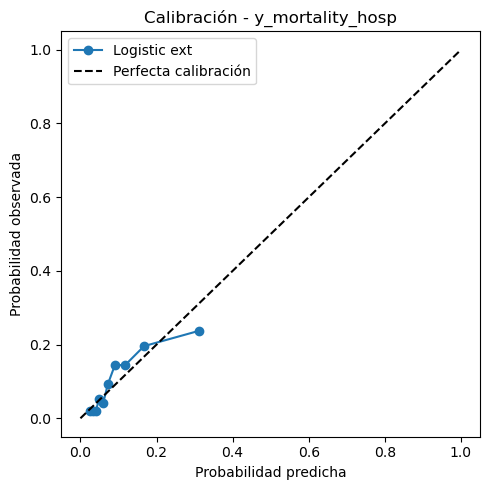

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Reutilizamos X, y, preprocess y logit_ext
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

logit_ext.fit(X_train, y_train)
y_prob = logit_ext.predict_proba(X_test)[:, 1]

# Brier score
brier = brier_score_loss(y_test, y_prob)
print(f"Brier score (Logistic ext -> {TARGET}): {brier:.3f}")

# Curva de calibración
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy="quantile")

plt.figure(figsize=(5, 5))
plt.plot(prob_pred, prob_true, "o-", label="Logistic ext")
plt.plot([0, 1], [0, 1], "k--", label="Perfecta calibración")
plt.xlabel("Probabilidad predicha")
plt.ylabel("Probabilidad observada")
plt.title(f"Calibración - {TARGET}")
plt.legend()
plt.tight_layout()
plt.show()


AUC logit ext: 0.7377059123219875


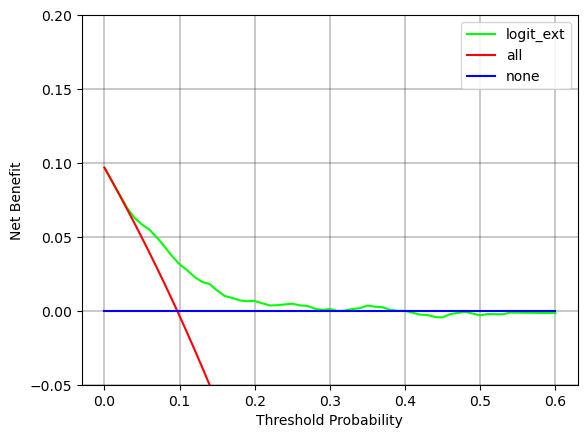

In [45]:
import numpy as np
import pandas as pd
from dcurves import dca

y_prob_logit = logit_ext.predict_proba(X_test)[:, 1]
print("AUC logit ext:", roc_auc_score(y_test, y_prob_logit))

# 4) DataFrame para dcurves: outcome + columna(s) de modelo(s)
dca_df = pd.DataFrame({
    "outcome": y_test.values,
    "logit_ext": y_prob_logit
})

# 5) Decision Curve Analysis con la misma sintaxis que el ejemplo
df_dca = dca(
    data=dca_df,
    outcome="outcome",
    modelnames=["logit_ext"],
    thresholds=np.arange(0, 0.61, 0.01),
)

# 6) Gráfico estándar de Net Benefit
dcurves.plot_graphs(
    plot_df=df_dca,
    graph_type="net_benefit",
    y_limits=[-0.05, 0.2]
)


In [44]:
import dcurves

print(dcurves.__version__)

1.1.7


AUC logit ext: 0.7377059123219875
AUC xgb ext: 0.6728207865304836
       model  threshold    n  prevalence  harm  test_pos_rate   tp_rate  \
0  logit_ext       0.00  971    0.096807   0.0       1.000000  0.096807   
1  logit_ext       0.01  971    0.096807   0.0       1.000000  0.096807   
2  logit_ext       0.02  971    0.096807   0.0       0.984552  0.096807   
3  logit_ext       0.03  971    0.096807   0.0       0.904222  0.094748   
4  logit_ext       0.04  971    0.096807   0.0       0.756952  0.090628   

    fp_rate  net_benefit  net_intervention_avoided  
0  0.903193     0.096807                       NaN  
1  0.903193     0.087684                  0.000000  
2  0.887745     0.078690                  0.015448  
3  0.809475     0.069712                  0.027120  
4  0.666323     0.062865                  0.088568  
Modelos en df_dca: ['logit_ext' 'xgb_ext' 'all' 'none']


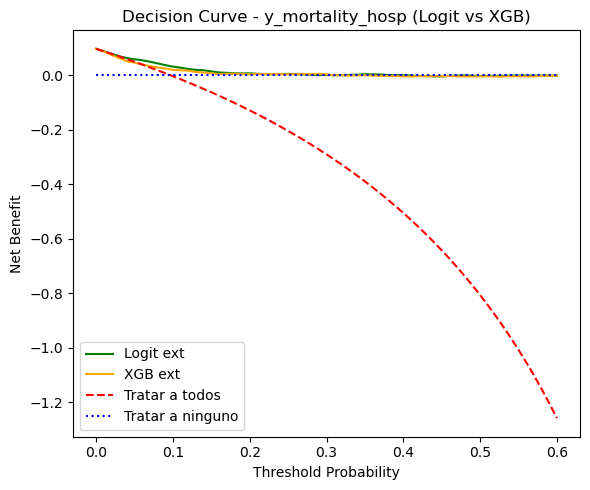

In [46]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import xgboost as xgb
from dcurves import dca
import matplotlib.pyplot as plt

# 1) Datos y variables
df = pd.read_csv("/Users/noelia/Downloads/cohort_alzheimer_ml_ready_with_outcomes.csv")

TARGET = "y_mortality_hosp"
y = df[TARGET].astype(int)

ding_vars = [
    "anchor_age",
    "resp_rate",
    "base_excess",
    "glucose",
    "rdw",
    "alkaline_phosphatase",
    "potassium",
    "hematocrit",
    "phosphate",
    "creatinine",
]
extra_vars_3 = ding_vars + ["sofa_total", "gcs_total", "cci", "acci"]
X = df[extra_vars_3]

preprocess = ColumnTransformer(
    transformers=[("num", StandardScaler(), extra_vars_3)]
)

# 2) Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# 3) Modelo logístico extendido
logit_ext = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(
        penalty=None,
        max_iter=5000
    ))
])
logit_ext.fit(X_train, y_train)
y_prob_logit = logit_ext.predict_proba(X_test)[:, 1]
print("AUC logit ext:", roc_auc_score(y_test, y_prob_logit))

# 4) Modelo XGBoost extendido
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=10.0,
    random_state=42
)
xgb_ext = Pipeline(steps=[
    ("prep", preprocess),
    ("model", xgb_model)
])
xgb_ext.fit(X_train, y_train)
y_prob_xgb = xgb_ext.predict_proba(X_test)[:, 1]
print("AUC xgb ext:", roc_auc_score(y_test, y_prob_xgb))

# 5) DataFrame para DCA
dca_df = pd.DataFrame({
    "outcome":   y_test.values,
    "logit_ext": y_prob_logit,
    "xgb_ext":   y_prob_xgb
})

# 6) Decision Curve con dcurves (API como en tu ejemplo)
df_dca = dca(
    data=dca_df,
    outcome="outcome",
    modelnames=["logit_ext", "xgb_ext"],
    thresholds=np.arange(0, 0.61, 0.01),
)

# 7) Gráfico manual de net benefit
# Mira estructura
print(df_dca.head())

# Asumiendo columnas estándar: 'threshold', 'model', 'net_benefit'
models = df_dca["model"].unique()
print("Modelos en df_dca:", models)

plt.figure(figsize=(6,5))

for m in models:
    sub = df_dca[df_dca["model"] == m]
    if m == "all":
        label = "Tratar a todos"
        style = "--"
        color = "red"
    elif m == "none":
        label = "Tratar a ninguno"
        style = ":"
        color = "blue"
    elif m == "logit_ext":
        label = "Logit ext"
        style = "-"
        color = "green"
    elif m == "xgb_ext":
        label = "XGB ext"
        style = "-"
        color = "orange"
    else:
        label = m
        style = "-"
        color = None
    plt.plot(sub["threshold"], sub["net_benefit"], linestyle=style, color=color, label=label)

plt.xlabel("Threshold Probability")
plt.ylabel("Net Benefit")
plt.title("Decision Curve - y_mortality_hosp (Logit vs XGB)")
plt.legend()
plt.tight_layout()
plt.show()


AUC logit ext (y_picu_long): 0.649852879361076
AUC xgb ext (y_picu_long): 0.6712204007285973
       model  threshold    n  prevalence  harm  test_pos_rate   tp_rate  \
0  logit_ext       0.00  971    0.120494   0.0       1.000000  0.120494   
1  logit_ext       0.01  971    0.120494   0.0       1.000000  0.120494   
2  logit_ext       0.02  971    0.120494   0.0       1.000000  0.120494   
3  logit_ext       0.03  971    0.120494   0.0       0.981462  0.118435   
4  logit_ext       0.04  971    0.120494   0.0       0.929969  0.116375   

    fp_rate  net_benefit  net_intervention_avoided  
0  0.879506     0.120494                       NaN  
1  0.879506     0.111610                  0.000000  
2  0.879506     0.102545                  0.000000  
3  0.863028     0.091743                 -0.050120  
4  0.813594     0.082475                 -0.032956  
Modelos en df_dca: ['logit_ext' 'xgb_ext' 'all' 'none']


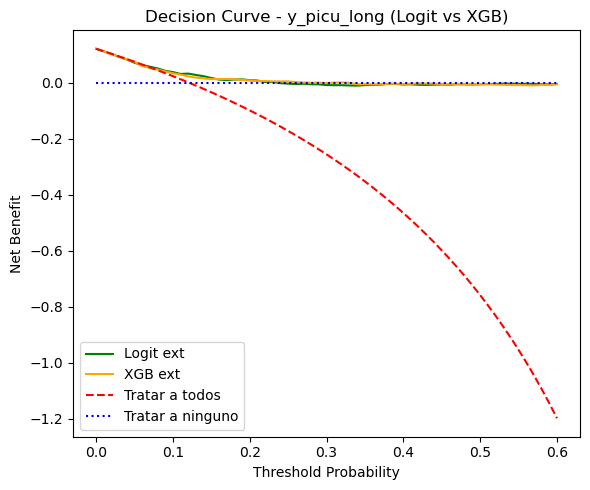

In [47]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import xgboost as xgb
from dcurves import dca
import matplotlib.pyplot as plt

# 1) Cargar datos y definir outcome LOS prolongada
df = pd.read_csv("/Users/noelia/Downloads/cohort_alzheimer_ml_ready_with_outcomes.csv")

TARGET = "y_picu_long"      # <- ahora LOS UCI prolongada
y = df[TARGET].astype(int)

# 2) Mismas variables extendidas (Ding + SOFA/GCS + CCI/aCCI)
ding_vars = [
    "anchor_age",
    "resp_rate",
    "base_excess",
    "glucose",
    "rdw",
    "alkaline_phosphatase",
    "potassium",
    "hematocrit",
    "phosphate",
    "creatinine",
]
extra_vars_3 = ding_vars + ["sofa_total", "gcs_total", "cci", "acci"]
X = df[extra_vars_3]

preprocess = ColumnTransformer(
    transformers=[("num", StandardScaler(), extra_vars_3)]
)

# 3) Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# 4) Modelo logístico extendido
logit_ext = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(
        penalty=None,
        max_iter=5000
    ))
])
logit_ext.fit(X_train, y_train)
y_prob_logit = logit_ext.predict_proba(X_test)[:, 1]
print("AUC logit ext (y_picu_long):", roc_auc_score(y_test, y_prob_logit))

# 5) Modelo XGBoost extendido
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=10.0,
    random_state=42
)
xgb_ext = Pipeline(steps=[
    ("prep", preprocess),
    ("model", xgb_model)
])
xgb_ext.fit(X_train, y_train)
y_prob_xgb = xgb_ext.predict_proba(X_test)[:, 1]
print("AUC xgb ext (y_picu_long):", roc_auc_score(y_test, y_prob_xgb))

# 6) DataFrame para DCA
dca_df = pd.DataFrame({
    "outcome":   y_test.values,
    "logit_ext": y_prob_logit,
    "xgb_ext":   y_prob_xgb
})

# 7) Decision Curve con dcurves
df_dca = dca(
    data=dca_df,
    outcome="outcome",
    modelnames=["logit_ext", "xgb_ext"],
    thresholds=np.arange(0, 0.61, 0.01),
)

print(df_dca.head())

# 8) Gráfico de net benefit
models = df_dca["model"].unique()
print("Modelos en df_dca:", models)

plt.figure(figsize=(6,5))

for m in models:
    sub = df_dca[df_dca["model"] == m]
    if m == "all":
        label = "Tratar a todos"
        style = "--"
        color = "red"
    elif m == "none":
        label = "Tratar a ninguno"
        style = ":"
        color = "blue"
    elif m == "logit_ext":
        label = "Logit ext"
        style = "-"
        color = "green"
    elif m == "xgb_ext":
        label = "XGB ext"
        style = "-"
        color = "orange"
    else:
        label = m
        style = "-"
        color = None

    plt.plot(sub["threshold"], sub["net_benefit"],
             linestyle=style, color=color, label=label)

plt.xlabel("Threshold Probability")
plt.ylabel("Net Benefit")
plt.title("Decision Curve - y_picu_long (Logit vs XGB)")
plt.legend()
plt.tight_layout()
plt.show()


In [48]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    precision_score, recall_score, confusion_matrix,
    brier_score_loss
)
from sklearn.calibration import calibration_curve

import xgboost as xgb
from dcurves import dca
import matplotlib.pyplot as plt

# ==========================
# 0. Datos y definición de bloques
# ==========================
df = pd.read_csv("/Users/noelia/Downloads/cohort_alzheimer_ml_ready_with_outcomes.csv")

outcomes = ["y_mortality_hosp", "y_picu_long"]  # 1) mortalidad, 2) LOS UCI prolongada

ding_vars = [
    "anchor_age",
    "resp_rate",
    "base_excess",
    "glucose",
    "rdw",
    "alkaline_phosphatase",
    "potassium",
    "hematocrit",
    "phosphate",
    "creatinine",
]

block_defs = {
    "Ding": ding_vars,
    "Ding+SOFA_GCS": ding_vars + ["sofa_total", "gcs_total"],
    "Ding+SOFA_GCS+CCI_aCCI": ding_vars + ["sofa_total", "gcs_total", "cci", "acci"],
}

# ==========================
# 1–3. Modelos, métricas y tablas
# ==========================

results_rows = []          # para tabla global de métricas
roc_objects = {}           # para guardar fpr, tpr
calib_objects = {}         # para curvas de calibración
probs_for_dca = {}         # para DCA logit vs XGB por outcome

for outcome in outcomes:
    print(f"\n=== OUTCOME: {outcome} ===")
    y = df[outcome].astype(int)

    for block_name, vars_block in block_defs.items():
        print(f"\n--- Block: {block_name} ---")
        for v in vars_block:
            if v not in df.columns:
                raise ValueError(f"Falta {v} en df.")

        X = df[vars_block]

        preprocess = ColumnTransformer(
            transformers=[("num", StandardScaler(), vars_block)]
        )

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )

        # Definir modelos
        models = {
            "Logistic": LogisticRegression(
                penalty=None,
                max_iter=5000
            ),
            "LASSO": LogisticRegressionCV(
                Cs=10,
                cv=5,
                penalty="l1",
                solver="saga",
                scoring="roc_auc",
                max_iter=5000
            ),
            "RandomForest": RandomForestClassifier(
                n_estimators=500,
                max_depth=None,
                random_state=42,
                n_jobs=-1
            ),
            "SVM": SVC(
                kernel="rbf",
                probability=True,
                C=1.0,
                gamma="scale",
                random_state=42
            ),
        }

        try:
            xgb_clf = xgb.XGBClassifier(
                objective="binary:logistic",
                eval_metric="logloss",
                n_estimators=500,
                max_depth=4,
                learning_rate=0.05,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_alpha=1.0,
                reg_lambda=10.0,
                random_state=42,
                n_jobs=-1
            )
            models["XGBoost"] = xgb_clf
        except Exception:
            pass

        for model_name, clf in models.items():
            pipe = Pipeline(steps=[
                ("prep", preprocess),
                ("model", clf)
            ])

            # Ajuste
            pipe.fit(X_train, y_train)

            # Probabilidades
            y_prob_train = pipe.predict_proba(X_train)[:, 1]
            y_prob_test  = pipe.predict_proba(X_test)[:, 1]

            # Métricas básicas
            auc_train = roc_auc_score(y_train, y_prob_train)
            auc_test  = roc_auc_score(y_test,  y_prob_test)

            y_pred = (y_prob_test >= 0.5).astype(int)
            precision = precision_score(y_test, y_pred)
            sensitivity = recall_score(y_test, y_pred)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            specificity = tn / (tn + fp)
            brier = brier_score_loss(y_test, y_prob_test)

            print(f"{model_name} | AUC train {auc_train:.3f} | AUC test {auc_test:.3f}")

            results_rows.append({
                "outcome": outcome,
                "block": block_name,
                "model": model_name,
                "AUC_train": auc_train,
                "AUC_test": auc_test,
                "precision": precision,
                "sensitivity": sensitivity,
                "specificity": specificity,
                "brier": brier
            })

            # Guardar objetos ROC y calibración para modelo estrella
            key = (outcome, block_name, model_name)

            fpr, tpr, _ = roc_curve(y_test, y_prob_test)
            roc_objects[key] = {
                "fpr": fpr,
                "tpr": tpr,
                "auc": auc_test
            }

            prob_true, prob_pred = calibration_curve(
                y_test, y_prob_test, n_bins=10, strategy="quantile"
            )
            calib_objects[key] = {
                "prob_true": prob_true,
                "prob_pred": prob_pred
            }

            # Guardar probas para DCA solo del bloque extendido y modelos Logit/XGB
            if block_name == "Ding+SOFA_GCS+CCI_aCCI" and model_name in ["Logistic", "XGBoost"]:
                if outcome not in probs_for_dca:
                    probs_for_dca[outcome] = {}
                probs_for_dca[outcome][model_name] = (y_test.values, y_prob_test)

# Tabla global de resultados
results_df = pd.DataFrame(results_rows)
results_df.to_csv("/Users/noelia/Downloads/ml_results_all_models.csv", index=False)
print("\nGuardado: ml_results_all_models.csv")



=== OUTCOME: y_mortality_hosp ===

--- Block: Ding ---
Logistic | AUC train 0.624 | AUC test 0.595
LASSO | AUC train 0.623 | AUC test 0.588
RandomForest | AUC train 1.000 | AUC test 0.556


/opt/anaconda3/envs/uoc20232pec1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM | AUC train 0.862 | AUC test 0.509
XGBoost | AUC train 0.975 | AUC test 0.555

--- Block: Ding+SOFA_GCS ---
Logistic | AUC train 0.708 | AUC test 0.714
LASSO | AUC train 0.708 | AUC test 0.714
RandomForest | AUC train 1.000 | AUC test 0.680
SVM | AUC train 0.870 | AUC test 0.586
XGBoost | AUC train 0.981 | AUC test 0.646

--- Block: Ding+SOFA_GCS+CCI_aCCI ---
Logistic | AUC train 0.737 | AUC test 0.738
LASSO | AUC train 0.736 | AUC test 0.740
RandomForest | AUC train 1.000 | AUC test 0.712
SVM | AUC train 0.886 | AUC test 0.582
XGBoost | AUC train 0.985 | AUC test 0.673

=== OUTCOME: y_picu_long ===

--- Block: Ding ---
Logistic | AUC train 0.639 | AUC test 0.535
LASSO | AUC train 0.640 | AUC test 0.539
RandomForest | AUC train 1.000 | AUC test 0.555
SVM | AUC train 0.813 | AUC test 0.527
XGBoost | AUC train 0.980 | AUC test 0.551

--- Block: Ding+SOFA_GCS ---
Logistic | AUC train 0.662 | AUC test 0.588
LASSO | AUC train 0.662 | AUC test 0.590
RandomForest | AUC train 1.000 | AUC t

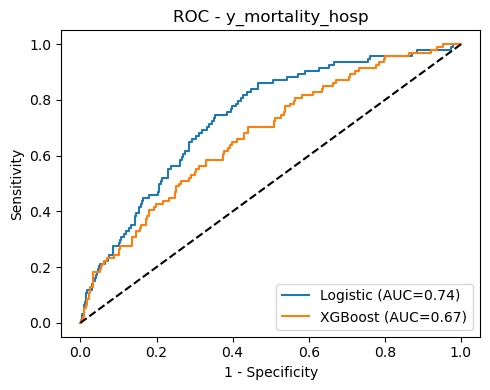

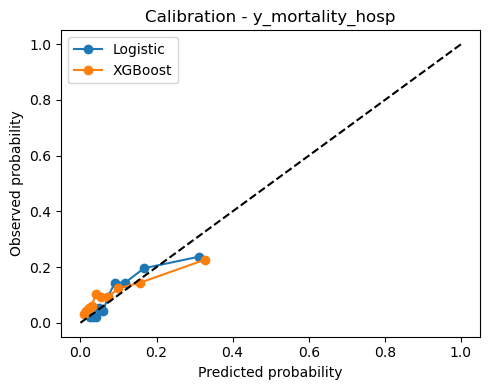

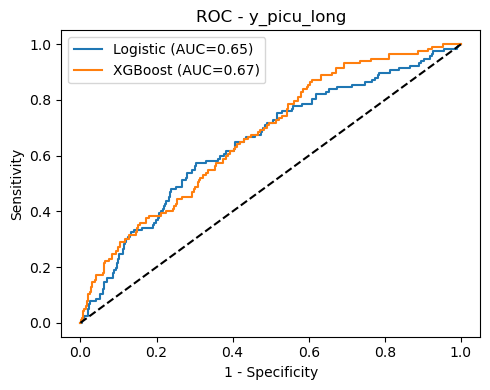

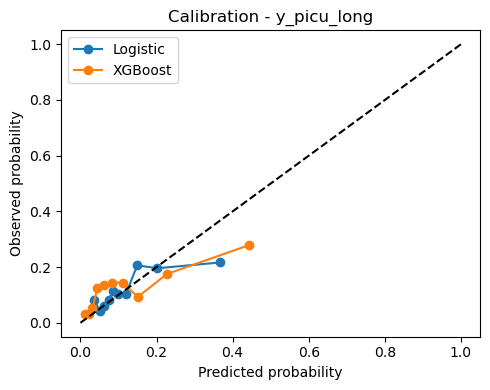

In [49]:
# ==========================
# ROC y calibración para bloque extendido, Logit vs XGB
# ==========================

for outcome in outcomes:
    plt.figure(figsize=(5,4))
    for model_name in ["Logistic", "XGBoost"]:
        key = (outcome, "Ding+SOFA_GCS+CCI_aCCI", model_name)
        if key not in roc_objects:
            continue
        fpr = roc_objects[key]["fpr"]
        tpr = roc_objects[key]["tpr"]
        auc = roc_objects[key]["auc"]
        label = f"{model_name} (AUC={auc:.2f})"
        plt.plot(fpr, tpr, label=label)
    plt.plot([0,1], [0,1], "k--")
    plt.xlabel("1 - Specificity")
    plt.ylabel("Sensitivity")
    plt.title(f"ROC - {outcome}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Calibración
    plt.figure(figsize=(5,4))
    for model_name in ["Logistic", "XGBoost"]:
        key = (outcome, "Ding+SOFA_GCS+CCI_aCCI", model_name)
        if key not in calib_objects:
            continue
        pt = calib_objects[key]["prob_true"]
        pp = calib_objects[key]["prob_pred"]
        plt.plot(pp, pt, marker="o", label=model_name)
    plt.plot([0,1], [0,1], "k--")
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed probability")
    plt.title(f"Calibration - {outcome}")
    plt.legend()
    plt.tight_layout()
    plt.show()



DCA head - y_mortality_hosp
       model  threshold    n  prevalence  harm  test_pos_rate   tp_rate  \
0  logit_ext       0.00  971    0.096807   0.0       1.000000  0.096807   
1  logit_ext       0.01  971    0.096807   0.0       1.000000  0.096807   
2  logit_ext       0.02  971    0.096807   0.0       0.984552  0.096807   
3  logit_ext       0.03  971    0.096807   0.0       0.904222  0.094748   
4  logit_ext       0.04  971    0.096807   0.0       0.756952  0.090628   

    fp_rate  net_benefit  net_intervention_avoided  
0  0.903193     0.096807                       NaN  
1  0.903193     0.087684                  0.000000  
2  0.887745     0.078690                  0.015448  
3  0.809475     0.069712                  0.027120  
4  0.666323     0.062865                  0.088568  


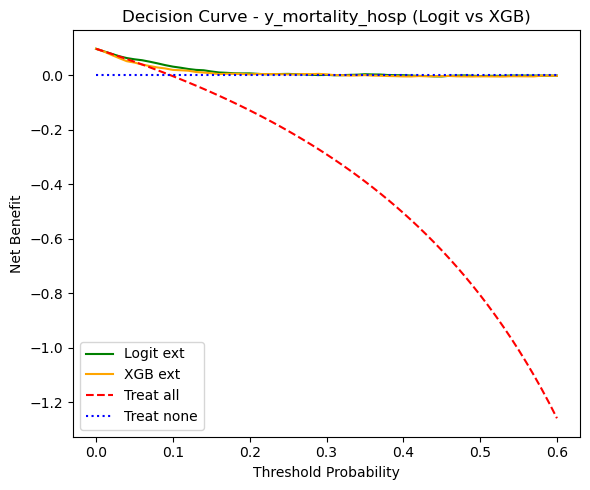


DCA head - y_picu_long
       model  threshold    n  prevalence  harm  test_pos_rate   tp_rate  \
0  logit_ext       0.00  971    0.120494   0.0       1.000000  0.120494   
1  logit_ext       0.01  971    0.120494   0.0       1.000000  0.120494   
2  logit_ext       0.02  971    0.120494   0.0       1.000000  0.120494   
3  logit_ext       0.03  971    0.120494   0.0       0.981462  0.118435   
4  logit_ext       0.04  971    0.120494   0.0       0.929969  0.116375   

    fp_rate  net_benefit  net_intervention_avoided  
0  0.879506     0.120494                       NaN  
1  0.879506     0.111610                  0.000000  
2  0.879506     0.102545                  0.000000  
3  0.863028     0.091743                 -0.050120  
4  0.813594     0.082475                 -0.032956  


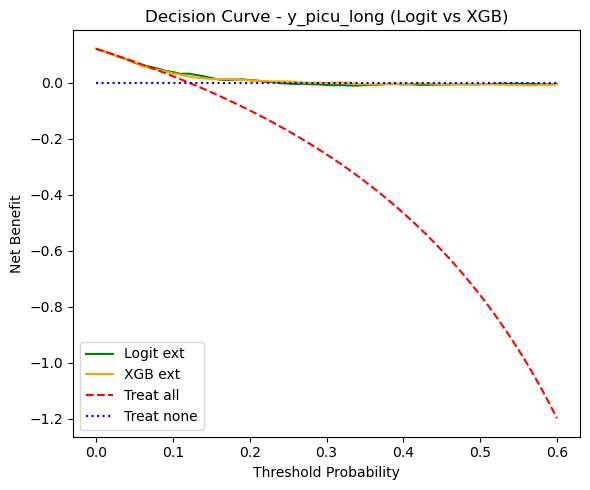

In [50]:
from dcurves import dca

for outcome in outcomes:
    if outcome not in probs_for_dca:
        continue
    y_test_vals, y_prob_logit = probs_for_dca[outcome]["Logistic"]
    _, y_prob_xgb = probs_for_dca[outcome]["XGBoost"]

    dca_df = pd.DataFrame({
        "outcome":   y_test_vals,
        "logit_ext": y_prob_logit,
        "xgb_ext":   y_prob_xgb
    })

    df_dca = dca(
        data=dca_df,
        outcome="outcome",
        modelnames=["logit_ext", "xgb_ext"],
        thresholds=np.arange(0, 0.61, 0.01),
    )

    print(f"\nDCA head - {outcome}")
    print(df_dca.head())

    models = df_dca["model"].unique()
    plt.figure(figsize=(6,5))
    for m in models:
        sub = df_dca[df_dca["model"] == m]
        if m == "all":
            label = "Treat all"
            style = "--"
            color = "red"
        elif m == "none":
            label = "Treat none"
            style = ":"
            color = "blue"
        elif m == "logit_ext":
            label = "Logit ext"
            style = "-"
            color = "green"
        elif m == "xgb_ext":
            label = "XGB ext"
            style = "-"
            color = "orange"
        else:
            label = m
            style = "-"
            color = None
        plt.plot(sub["threshold"], sub["net_benefit"],
                 linestyle=style, color=color, label=label)

    plt.xlabel("Threshold Probability")
    plt.ylabel("Net Benefit")
    plt.title(f"Decision Curve - {outcome} (Logit vs XGB)")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import ipywidgets as widgets
from ipywidgets import VBox
from IPython.display import display, Markdown

# 1. Cargar datos
df = pd.read_csv("/Users/noelia/Downloads/cohort_alzheimer_ml_ready_with_outcomes.csv")
COL_MORT = "y_mortality_hosp"
COL_LOS  = "y_picu_long"

# 2. Definir predictores 
vars_ding = [
    "anchor_age",
    "resp_rate",
    "base_excess",
    "glucose",
    "rdw",
    "alkaline_phosphatase",
    "potassium",
    "hematocrit",
    "phosphate",
    "creatinine",
]
vars_extra = ["sofa_total", "gcs_total", "cci", "acci"]
vars_block3 = vars_ding + vars_extra

X = df[vars_block3].copy()

# 3. Estandarizar predictores 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def fit_logit(target_colname):
    if target_colname not in df.columns:
        raise ValueError(f"No encuentro la columna {target_colname} en el CSV.")
    y = df[target_colname].astype(int)
    logit = LogisticRegression(penalty=None, max_iter=5000)
    logit.fit(X_scaled, y)
    return logit

# 4. Ajustar los dos modelos 
logit_mort = fit_logit(COL_MORT)
logit_los  = fit_logit(COL_LOS)

# 5. Crear sliders 
sliders = {}
for v in vars_block3:
    v_min = float(df[v].quantile(0.01))
    v_max = float(df[v].quantile(0.99))
    v_med = float(df[v].median())
    sliders[v] = widgets.FloatSlider(
        description=v,
        value=v_med,
        min=v_min,
        max=v_max,
        step=(v_max - v_min) / 100.0,
        continuous_update=False,
        layout=widgets.Layout(width="95%")
    )

# 6. Función que calcula y muestra los riesgos
def update_risks(**kwargs):
    vals = [kwargs[v] for v in vars_block3]
    # DataFrame con nombres de columnas para evitar el warning del scaler
    x_df = pd.DataFrame([vals], columns=vars_block3)
    x_scaled = scaler.transform(x_df)

    p_mort = logit_mort.predict_proba(x_scaled)[0, 1]
    p_los  = logit_los.predict_proba(x_scaled)[0, 1]

    display(Markdown(
        f"**Riesgo de mortalidad hospitalaria:** {p_mort*100:.1f}%  \n"
        f"**Riesgo de estancia UCI prolongada:** {p_los*100:.1f}%"
    ))

# 7. Montar interfaz interactiva
ui = VBox(list(sliders.values()))
out = widgets.interactive_output(update_risks, sliders)

display(Markdown("### Nomograma interactivo"))
display(ui, out)
